In [1]:
# https://github.com/higgsfield/RL-Adventure/blob/master/1.dqn.ipynb

In [2]:
# DQN without a frozen target network

In [3]:
import yaml

In [4]:
# FROM CONFIG FILE
# config_path =  './base_config.yaml' # sys.argv[1]
config_path =  './exp_1.yaml' # sys.argv[1]
config = yaml.safe_load(open(config_path,'r'))
# Set a seed value: 
seed_value = 12321  

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value: 
import os 
os.environ['PYTHONHASHSEED']=str(seed_value) 
# 2. Set `python` built-in pseudo-random generator at a fixed value: 
import random 
random.seed(seed_value) 
# 3. Set `numpy` pseudo-random generator at a fixed value:
import numpy as np 
np.random.seed(seed_value) 
# 4. Set `tensorflow` pseudo-random generator at a fixed value: 
import tensorflow as tf 
tf.random.set_random_seed(seed_value)
# 5. Set `torch` pseudo-random generator at a fixed value: 
import torch
torch.manual_seed(seed_value)
# 6. Set CUDNN to be deterministic:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
import math, random

import gym
import numpy as np


import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter


In [6]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

In [7]:
USE_GPU = config['USE_GPU']
# epsilon_start = 1.0
# epsilon_final = 0.01
# HIDDEN_LAYER = 128
# OPTIMIZER = Adam
# REPLAY_BUFFER_SIZE = 1000
# LEARNING_RATE = 0.1
# num_frames = 10000
# batch_size = 32
# gamma      = 0.99
# loss function
# target_replace

In [8]:
# Use CUDA
USE_CUDA = torch.cuda.is_available() and USE_GPU
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

if USE_CUDA:
  torch.cuda.manual_seed(seed_value)

In [9]:
# REPLAY BUFFER

from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [10]:
# CartPole-v0 Environment

env_id = "CartPole-v0"
env = gym.make(env_id)

In [11]:
# e-greedy exploration

epsilon_start = config['EPSILON_START']
epsilon_final = config['EPSILON_FINAL']
epsilon_decay = config['EPSILON_DECAY']

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

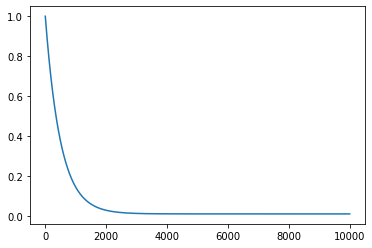

In [12]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

In [13]:
# Deep Q-Networks

class DQN(nn.Module): #base model
    def __init__(self, num_inputs, num_actions, HIDDEN_LAYER_WIDTH):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], HIDDEN_LAYER_WIDTH),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_WIDTH, HIDDEN_LAYER_WIDTH),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_WIDTH, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [14]:
# MODEL
if (config['MODEL_NAME']=='DQN'):
    model = DQN(env.observation_space.shape[0], 
                env.action_space.n,
                config['HIDDEN_LAYER_WIDTH'])
else: #default model is DQN class
    model = DQN(env.observation_space.shape[0], 
                env.action_space.n,
                config['HIDDEN_LAYER_WIDTH'])    
if USE_CUDA:
    model = model.cuda()

In [15]:
# OPTIMIZER
if (config['OPTIMIZER']=='Adam'):
    optimizer = optim.Adam(model.parameters(), 
                           lr=config['LEARNING_RATE'])
elif (config['OPTIMIZER']=='SGD'):
    optimizer = optim.SGD(model.parameters(), 
                           lr=config['LEARNING_RATE'])
else: #default optimizer is Adam
    optimizer = optim.Adam(model.parameters(), 
                           lr=config['LEARNING_RATE'])

In [16]:
# CRITERION
if (config['CRITERION']=='MSE'):
    criterion = nn.MSELoss()
elif (config['CRITERION']=='HUBER'):
    criterion = nn.SmoothL1Loss()
else: #default criterion is MSELoss
    criterion = nn.MSELoss()

In [17]:
# REPLAY BUFFER
replay_buffer = ReplayBuffer(capacity=config['REPLAY_BUFFER_SIZE'])

In [18]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    loss = criterion(q_value, expected_q_value)
       
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [19]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

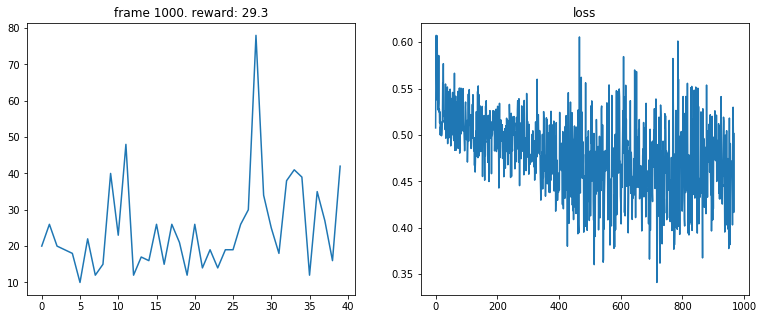

In [20]:
# Training

num_frames = config['TIMESTEPS']
batch_size = config['BATCH_SIZE']
gamma      = config['GAMMA']

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)